Carlos Espeleta

Tuesday 18 July, 2023

# Demand Forecasting Data Science Challenge

## Required Task

We ask you to help us out with the problem of forecasting the daily number of orders. We have the daily number of (simulated) orders for Berlin, Germany from 2nd May 2020 until 30 June 2022. In addition, we have collected data for the temperature and marketing spend.

## Business requirements

- We are required to run the model every Monday morning and get predictions for the upcoming 2 weeks. Note that the values in the temperature column are real values, hence are just available for current and past days. On the other hand, marketing spend is a feature we can know in advance, so it is available at prediction time.
- Moreover, we are not just interested in the point predictions but also in the uncertainty of the predictions.
- Before putting this model into production, we need to assess model performance, so please provide information about the out-of-sample-expected performance.

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import datetime as dt
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
from sklearn import set_config
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (
    make_scorer,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
)

from src.constants import MONTH_NAME, SEASONS, SEASONS_MAPPING, WEEKDAY_NAME
from src.cross_validation import (
    cross_validation_coverage,
    cross_validation_intervals,
    cross_validation_predict,
)
from src.plotting.eda import plot_lags
from src.uncertainty import (
    calculate_prediction_intervals,
    get_residuals_quantile,
)

set_config(transform_output="pandas")

In [3]:
custom_params = {
    "figure.dpi": 100,
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(style="ticks", rc=custom_params)

In [4]:
path_images = Path("images")
path_images.mkdir(exist_ok=True)

# Read data

In [5]:
dtypes = {
    "orders": int,
    "temperature": float,
    "media_spend": float,
}

In [6]:
df = pd.read_csv("data/data.csv", parse_dates=["date"], dtype=dtypes)
df.sort_values(by="date", ascending=True, inplace=True)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (790, 4)


,date,orders,temperature,media_spend
0,2020-05-02,54,18.270322,0.0
1,2020-05-03,63,19.882444,0.0
2,2020-05-04,56,16.878095,0.0
3,2020-05-05,65,21.878648,0.0
4,2020-05-06,64,21.112398,0.0


# EDA

The provided dataset contains 790 observations and 4 variables, which are observation dates, numbers of orders for Belin, temperature of the city and the marketing spend. The dataset is in daily granularity, which is a little bit more than 2 years of data.

- Orders are positive, with a minimum values of 40 units. Orders contains outliers because its maximum value is 4080 units which is too high compared to the 75% percentile.
- Temperature has positive and negative values (winter in Berlin is cold).
- Media spend has values from 0 to 14.99.

In [7]:
df.describe().style.format(precision=2)

,date,orders,temperature,media_spend
count,790,790.00,769.00,790.00
mean,2021-05-31 12:00:00,89.06,17.36,0.50
min,2020-05-02 00:00:00,40.00,-9.98,0.00
25%,2020-11-15 06:00:00,67.25,11.00,0.00
50%,2021-05-31 12:00:00,78.00,18.29,0.00
75%,2021-12-14 18:00:00,86.00,24.02,0.00
max,2022-06-30 00:00:00,4080.00,37.95,14.99
std,nan,200.77,9.88,2.67


Temperature contains missing values.

In [8]:
df.isnull().sum()

date            0
orders          0
temperature    21
media_spend     0
dtype: int64

Check for unique dates

In [9]:
print(f"Date is unique: {df.date.is_unique}")
print(f"Date is monotonic_increasing: {df.date.is_monotonic_increasing}")

Date is unique: True
Date is monotonic_increasing: True


## Visualize orders

To get a quick understanding of the data let's visualize the orders.

In [10]:
def format_date_axis(ax, interval: int = 3, format: str = "%b\n%Y") -> None:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    months_fmt = mdates.DateFormatter(format)
    ax.xaxis.set_major_formatter(months_fmt)

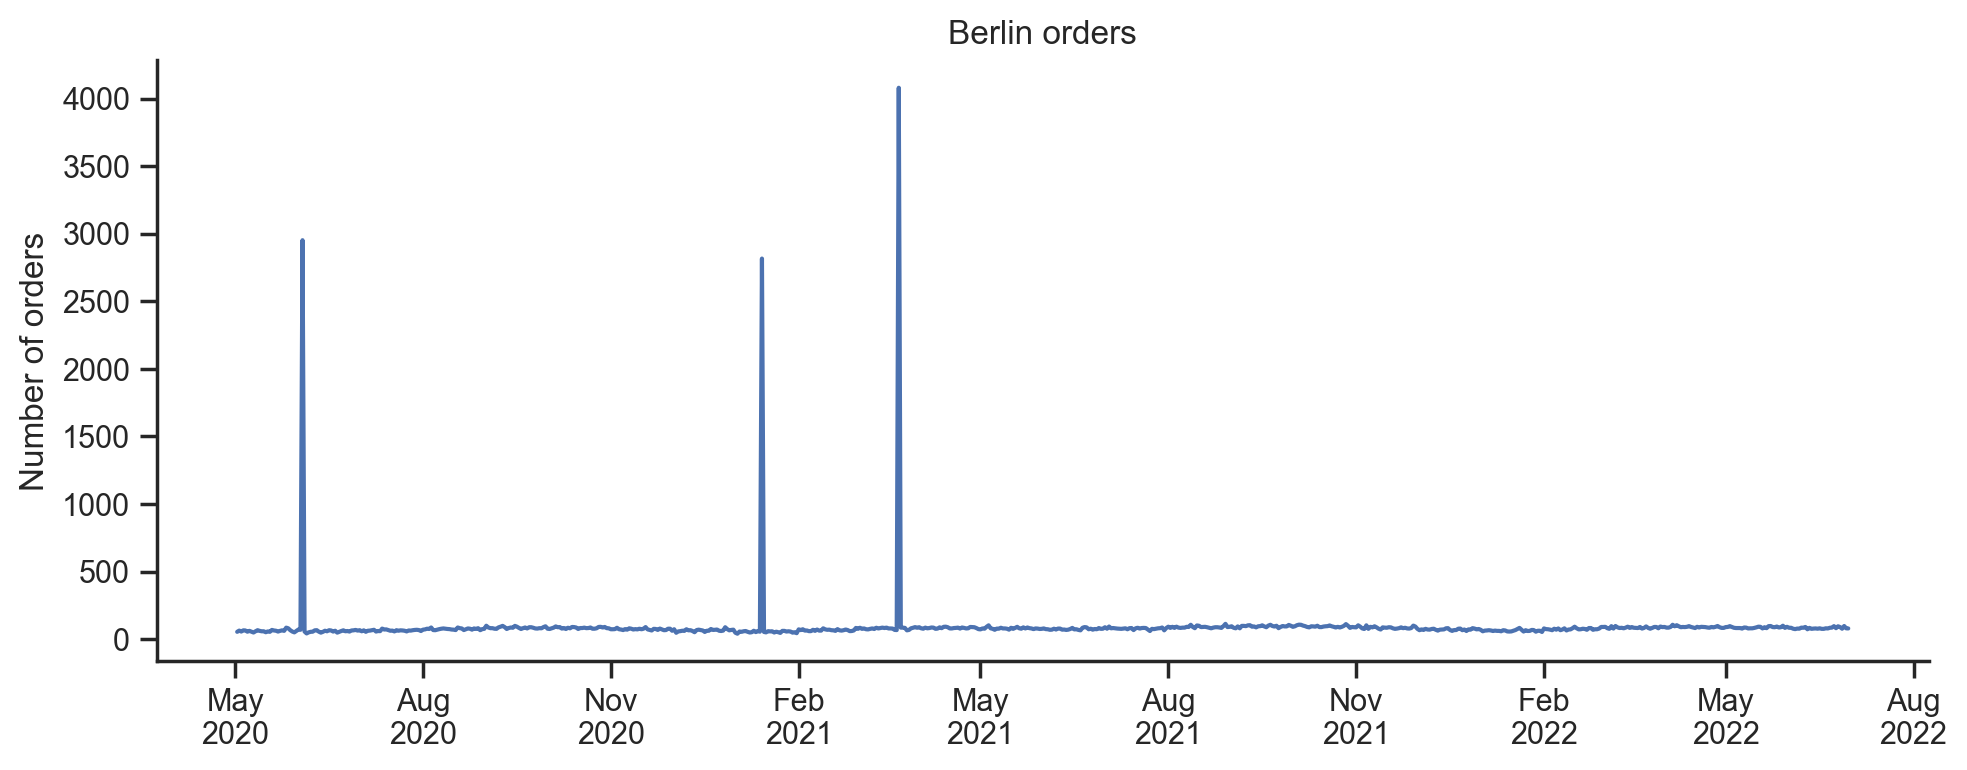

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x="date", y="orders", ax=ax)
ax.set(title="Berlin orders", xlabel=None, ylabel="Number of orders")
format_date_axis(ax)
fig.tight_layout()
plt.savefig(path_images / "orders.png")
plt.show()

As expected from the table above, orders contain outliers. Before treat them, it is important to uderstand why they exist:
- Is it because of a problem in our ETL?
- Is it because Wolt ran marketing campaigns that affected the number of orders? In this case the impact seems to be to high.
- Is it because of an special event in the city?
- Is it because a direct competitor of Wolt had problems in Berlin and Wolt received more orders than expected?

## Outliers

Outliers affect the performance of the model and need to be treated before continue. This is a two step process, first detect the outliers and second fix them.

In cases like this, with one or two time series outliers can be manualy identified, however the problem starts to get more challenging when dealing with thousands of series.

How to identify outliers:
- Manual identification
- Computing rolling metrics such as rolling standard deviation, quantiles, etc.
- Descompose the serie into trend, season and remainder and look at its components.

In [12]:
df = df.assign(is_outlier=lambda x: x.orders > 250)

In [13]:
df.query("is_outlier")

,date,orders,temperature,media_spend,is_outlier
32,2020-06-03,2952,9.493584,0.0,True
257,2021-01-14,2816,-4.468595,0.0,True
324,2021-03-22,4080,20.155265,0.0,True


Interpolate outliers

In [14]:
df = df.assign(
    orders_clean=lambda x: x.orders.mask(x.is_outlier, np.nan).interpolate(
        method="linear"
    )
)

Visualize orders

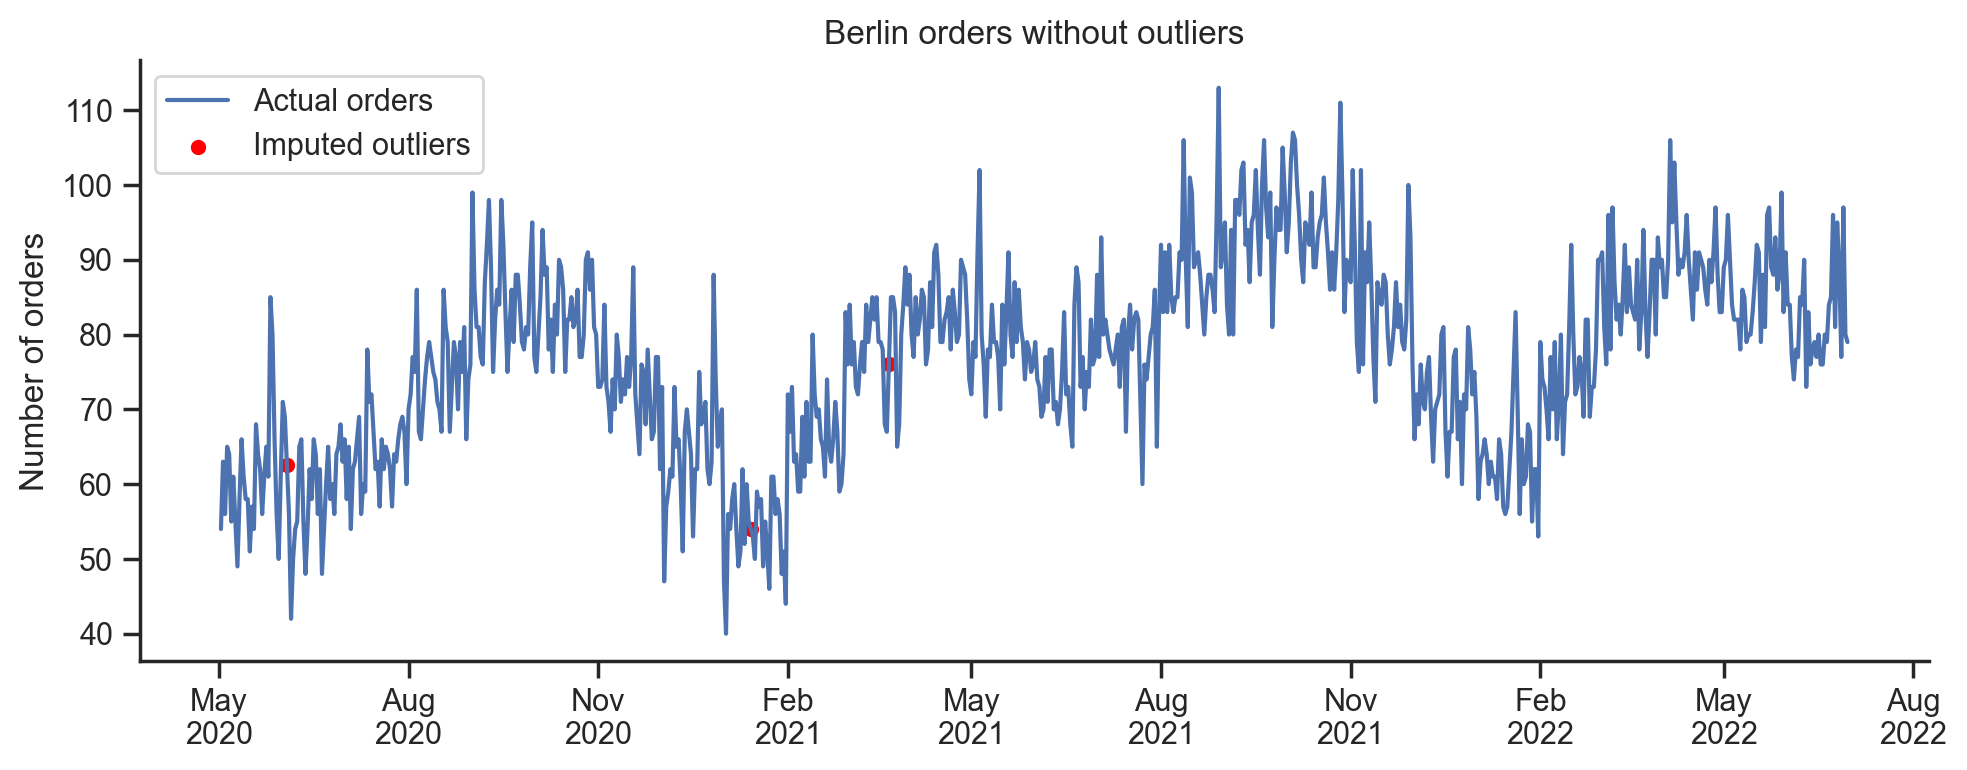

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x="date", y="orders_clean", label="Actual orders", ax=ax)
sns.scatterplot(
    data=df.query("is_outlier"),
    x="date",
    y="orders_clean",
    color="red",
    label="Imputed outliers",
    ax=ax,
)
ax.set(title="Berlin orders without outliers", xlabel=None, ylabel="Number of orders")
format_date_axis(ax)
fig.tight_layout()
plt.savefig(path_images / "orders_clean.png")
plt.show()

## Missing data

The average temperature of a city has a gradual transition, that is, it does not change abruptly from one day to the next. For that reason, missing values has been imputed with previous day's value.

However, in real life, one should understand why these missing values are in the data set:
- Is it because of a problem in our ETL?
- Is it because of a provider problem?

In [16]:
df = df.assign(
    missing_temp=lambda x: x.temperature.isnull(),
    temperature=lambda x: x.temperature.fillna(method="ffill"),
)

In [17]:
# safety check
# df.isnull().sum()

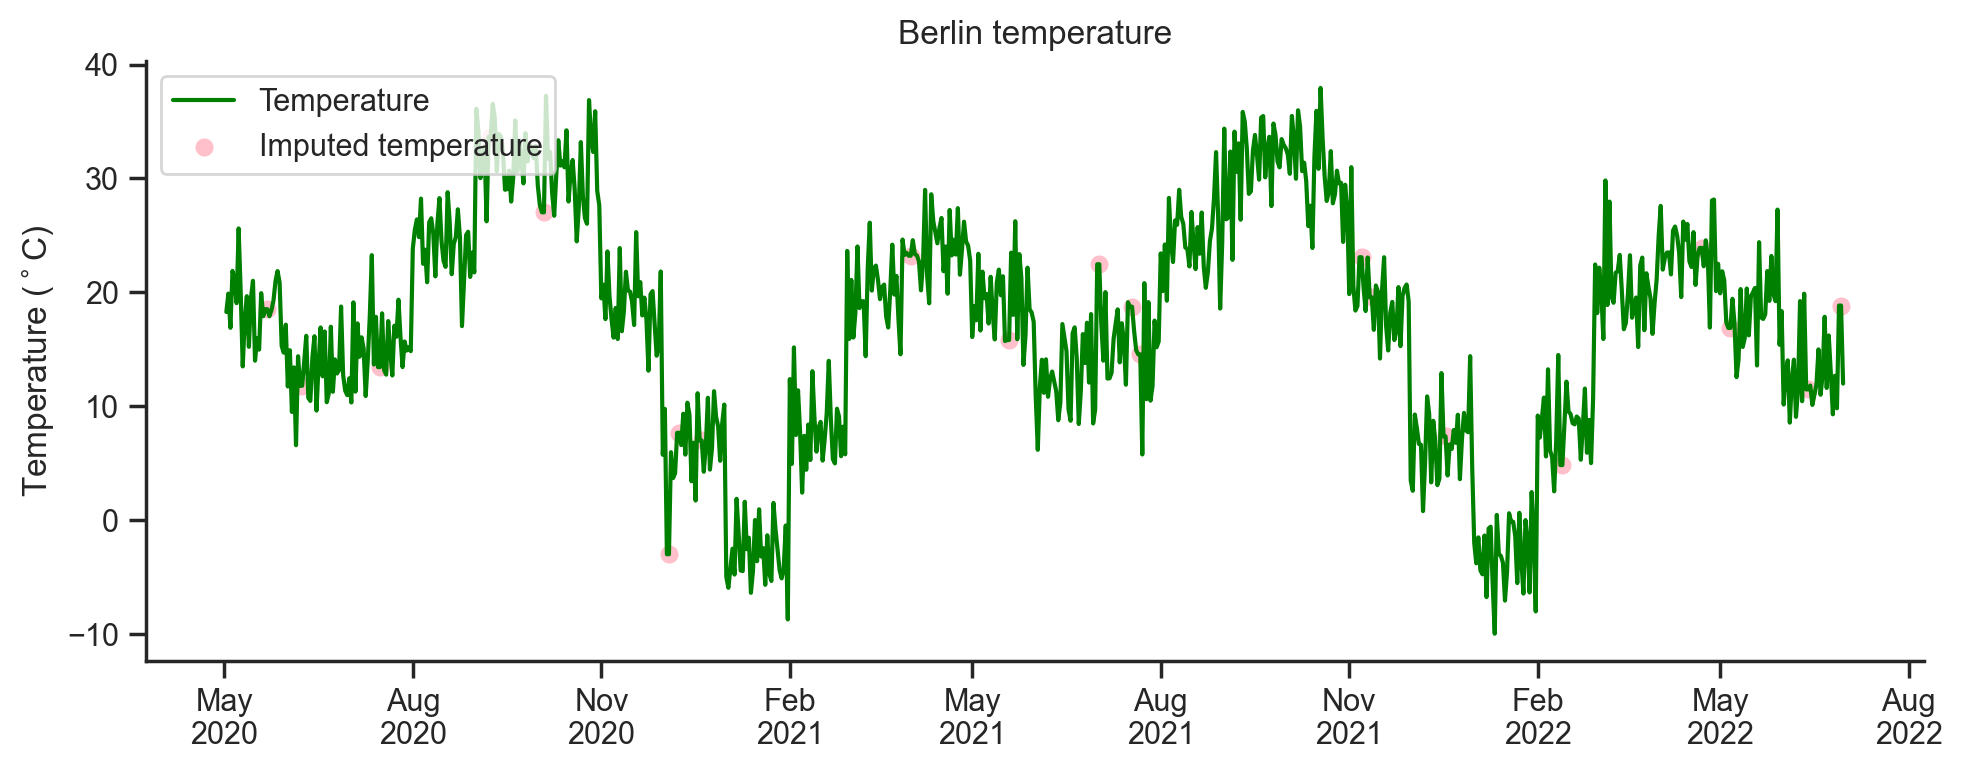

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    data=df, x="date", y="temperature", label="Temperature", color="green", ax=ax
)
sns.scatterplot(
    data=df.query("missing_temp"),
    x="date",
    y="temperature",
    color="pink",
    label="Imputed temperature",
    s=50,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Berlin temperature", xlabel=None, ylabel=r"Temperature ($^\circ$C)")
format_date_axis(ax)
fig.tight_layout()
plt.savefig(path_images / "temperature.png")
plt.show()

The correlation between the orders and the temperature is 0,72, so the temperature will be a potencial predictor of the model. From a business point of view, I would have expected higher number of orders when temperatures are low because people prefer to stay at home.

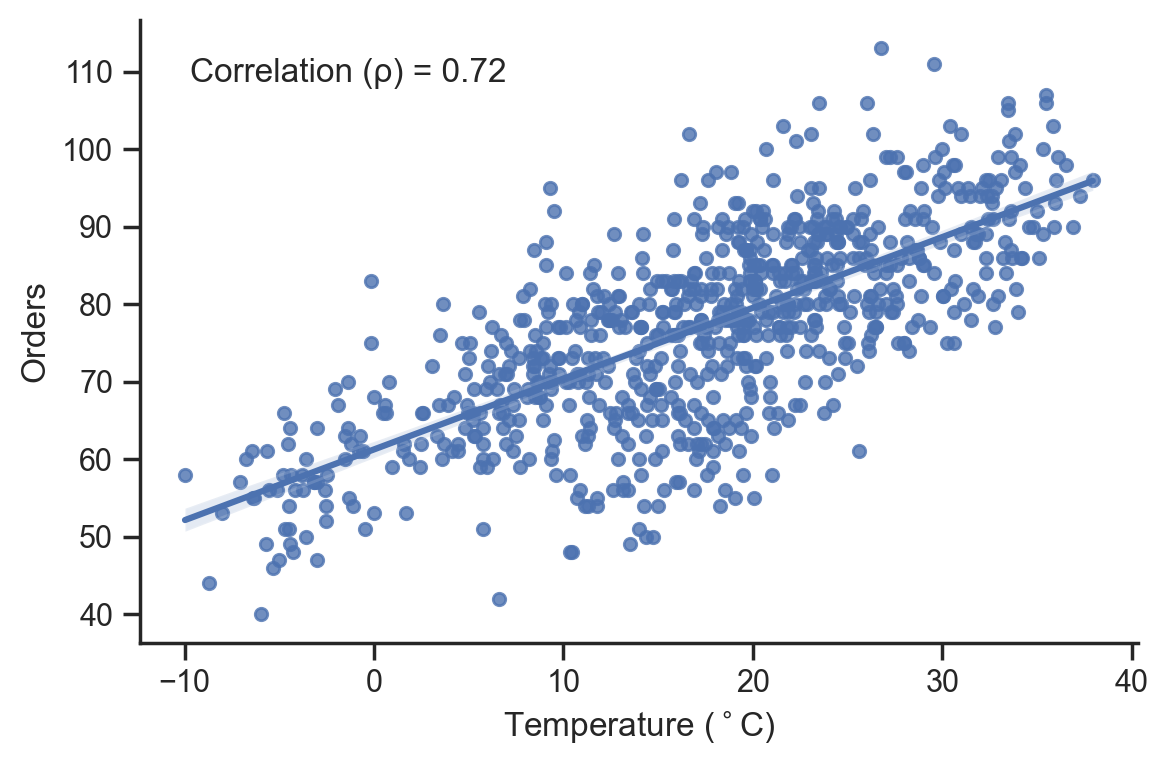

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(
    df, x="temperature", y="orders_clean", robust=True, ax=ax, scatter_kws={"s": 20}
)
ax.set(xlabel=r"Temperature ($^\circ$C)", ylabel="Orders")
r = np.corrcoef(df.orders_clean, df.temperature)[0][1]
ax.annotate(f"Correlation (ρ) = {r:.2f}", xy=(0.05, 0.9), xycoords=ax)
fig.tight_layout()
plt.savefig(path_images / "orders_vs_temperature.png")
plt.show()

## Marketing

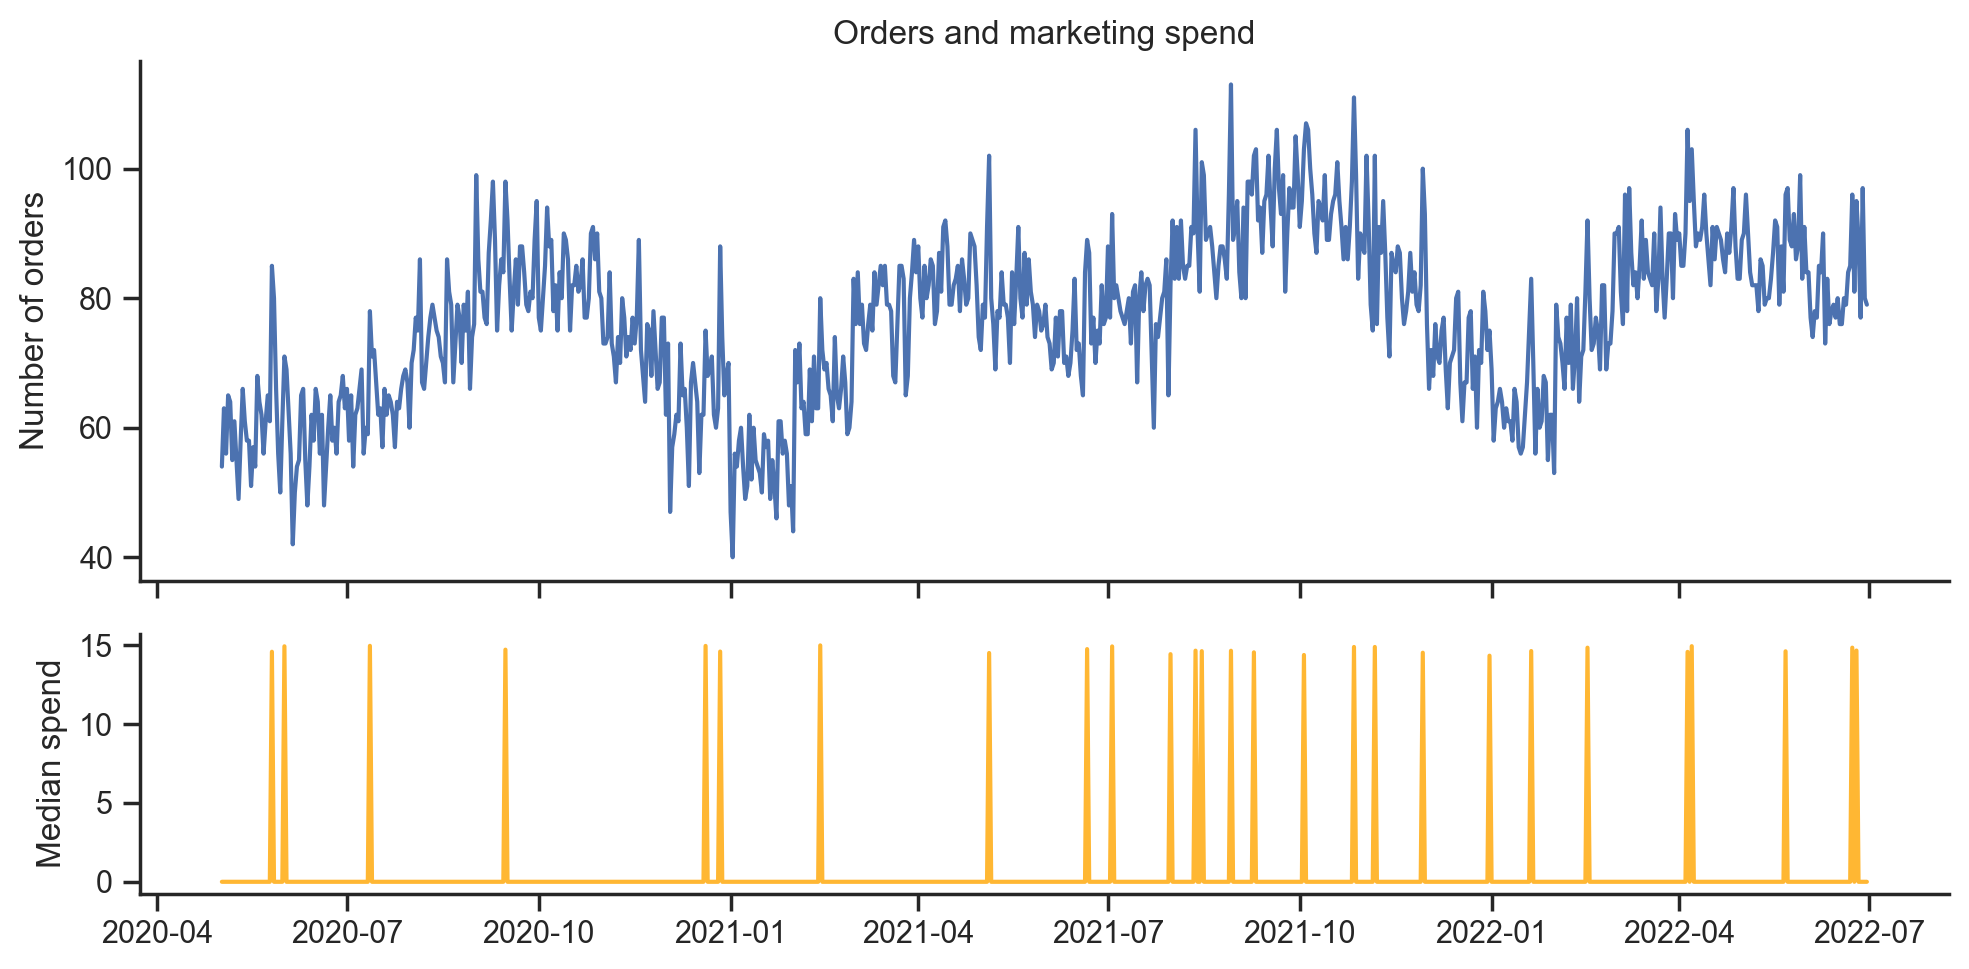

In [20]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 5),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]},
)
sns.lineplot(df, x="date", y="orders_clean", ax=axs[0])
axs[0].set(title="Orders and marketing spend", ylabel="Number of orders")
sns.lineplot(df, x="date", y="media_spend", color="orange", alpha=0.8, ax=axs[1])
axs[1].set(xlabel=None, ylabel="Median spend")

format_date_axis(ax)
fig.tight_layout()
plt.savefig(path_images / "marketing.png")
plt.show()

Things to consider when modeling a marketing campaign:

- There is a time lag between the campaign and its effect (although less and less due to mobile applications).
- The effect of the campaign lasts over time

For example, if the campaign was carried out on a Monday (orange bar) the following days will also be affected by it, although to a lesser extent. This behaviour can be modeled with an exponential decay (blue dashed line).

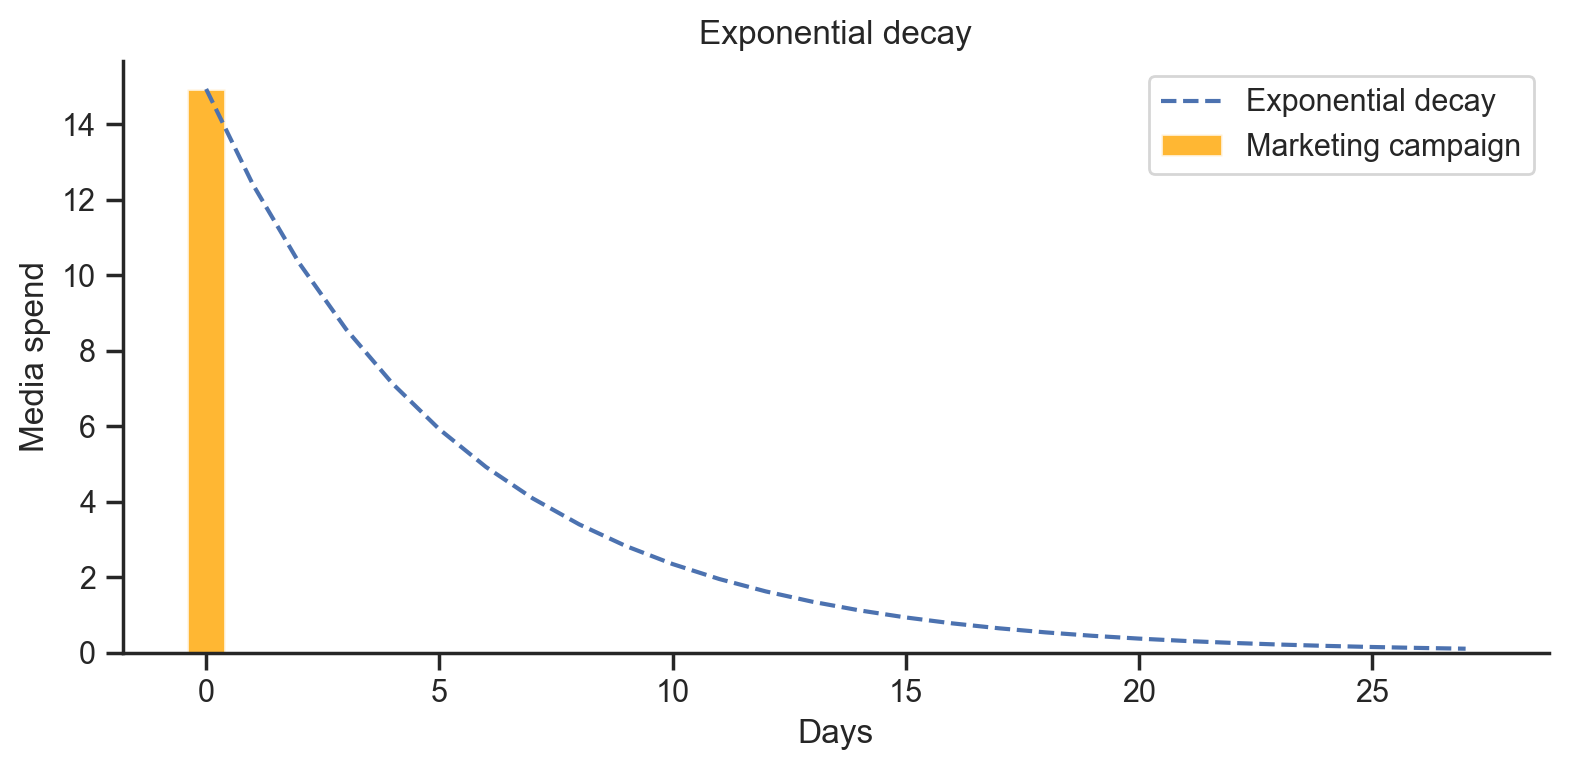

In [21]:
spend = 14.93
n_obs = 28

t = np.linspace(0, 10, num=n_obs)
s = np.zeros(n_obs)
s[0] = spend
e = spend * np.exp(-0.5 * t)

fig, ax = plt.subplots(figsize=(8, 4))
plt.bar(range(len(s)), s, color="orange", alpha=0.8, label="Marketing campaign")
plt.plot(e, linestyle="--", label="Exponential decay")
plt.xlabel("Days")
plt.ylabel("Media spend")
plt.title("Exponential decay")
plt.legend()
fig.tight_layout()
plt.savefig(path_images / "marketing_exponential_decay.png")
plt.show()

In general, distributions are more or less normal.

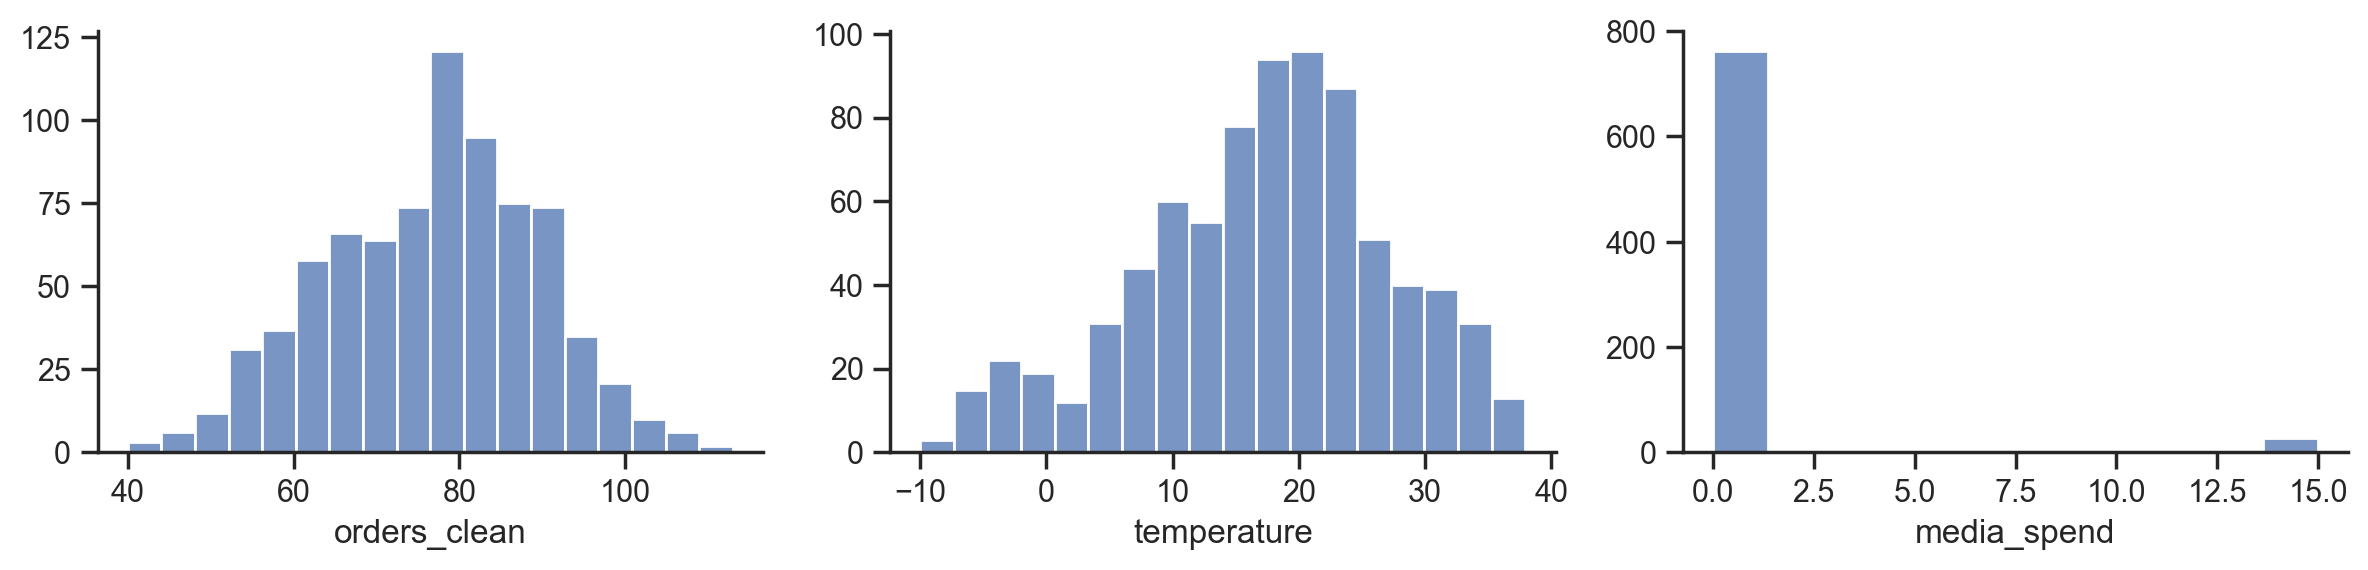

In [22]:
cols = ["orders_clean", "temperature", "media_spend"]
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for col, ax in zip(cols, axs.flatten()):
    sns.histplot(df, x=col, ax=ax)
    ax.set(ylabel=None)
fig.tight_layout()
plt.show()

## Seasonality

In [23]:
def add_date_features(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Add date components to the existing DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a date column.

    col : str
        Date column that will be used to extract the information

    Returns
    -------
    df : pd.DataFrame
        DataFrame with initial columns + date columns generated
    """
    return df.assign(
        season=lambda x: pd.Categorical(
            values=x[col].dt.month.map(SEASONS_MAPPING), categories=SEASONS
        ),
        year=lambda x: x[col].dt.year,
        month=lambda x: pd.Categorical(
            values=x[col].dt.month_name(), categories=MONTH_NAME
        ),
        month_idx=lambda x: x[col].dt.month,
        weekday=lambda x: pd.Categorical(
            values=x[col].dt.day_name(), categories=WEEKDAY_NAME
        ),
        weekday_idx=lambda x: x[col].dt.day_of_week,
        type_of_day=lambda x: pd.Categorical(
            np.where(x[col].dt.day_of_week > 4, "Weekend", "Weekday"),
            categories=["Weekday", "Weekend"],
        ),
    )

In [24]:
df = add_date_features(df, "date")

## Weekly seasonality

There is an upward trend from Monday to Wednesday. As of Wednesday, the numbers of orders begins to decrease, with Friday and Saturday being the days with the lowest number of orders.

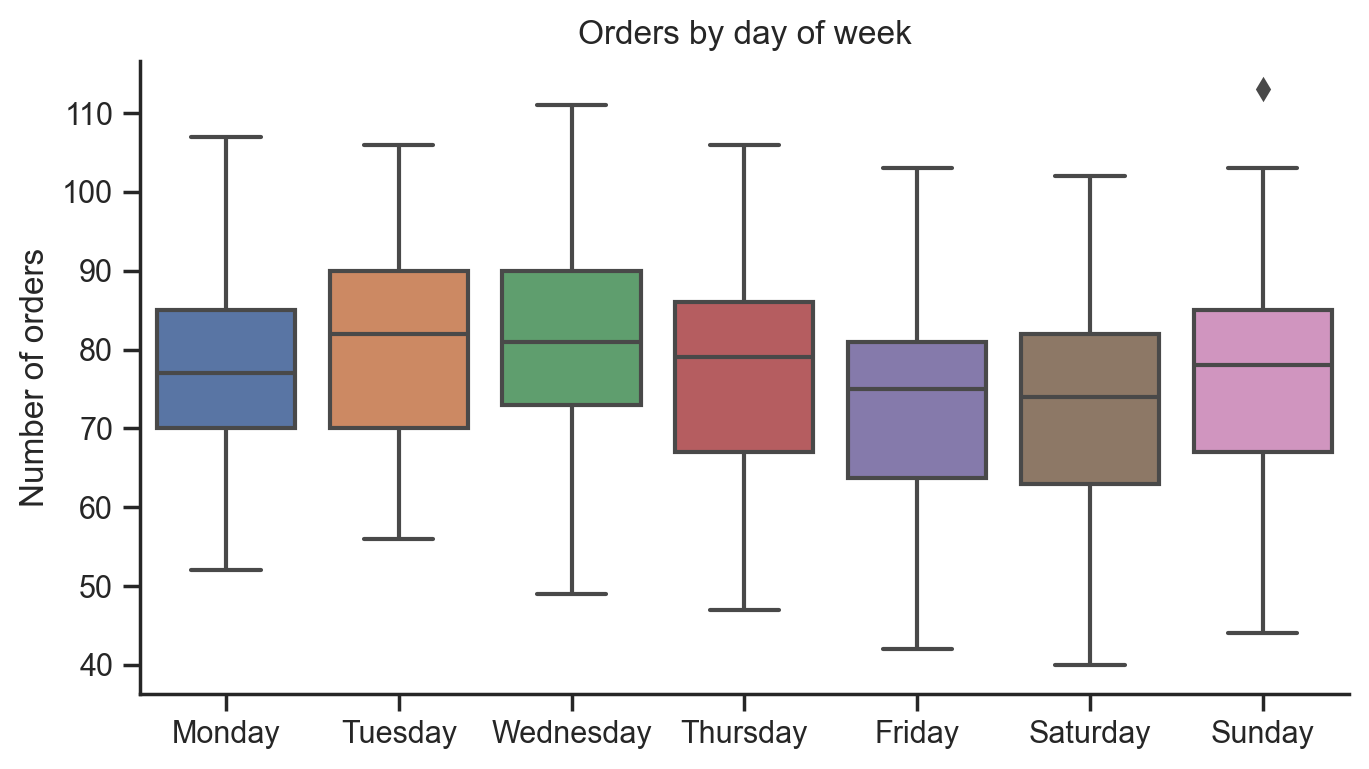

In [25]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df, x="weekday", y="orders_clean", ax=ax)
ax.set(title="Orders by day of week", xlabel=None, ylabel="Number of orders")
fig.tight_layout()
plt.savefig(path_images / "orders_by_dayofweek.png")
plt.show()

As we have seen, more orders are received during weekdays than weekends.

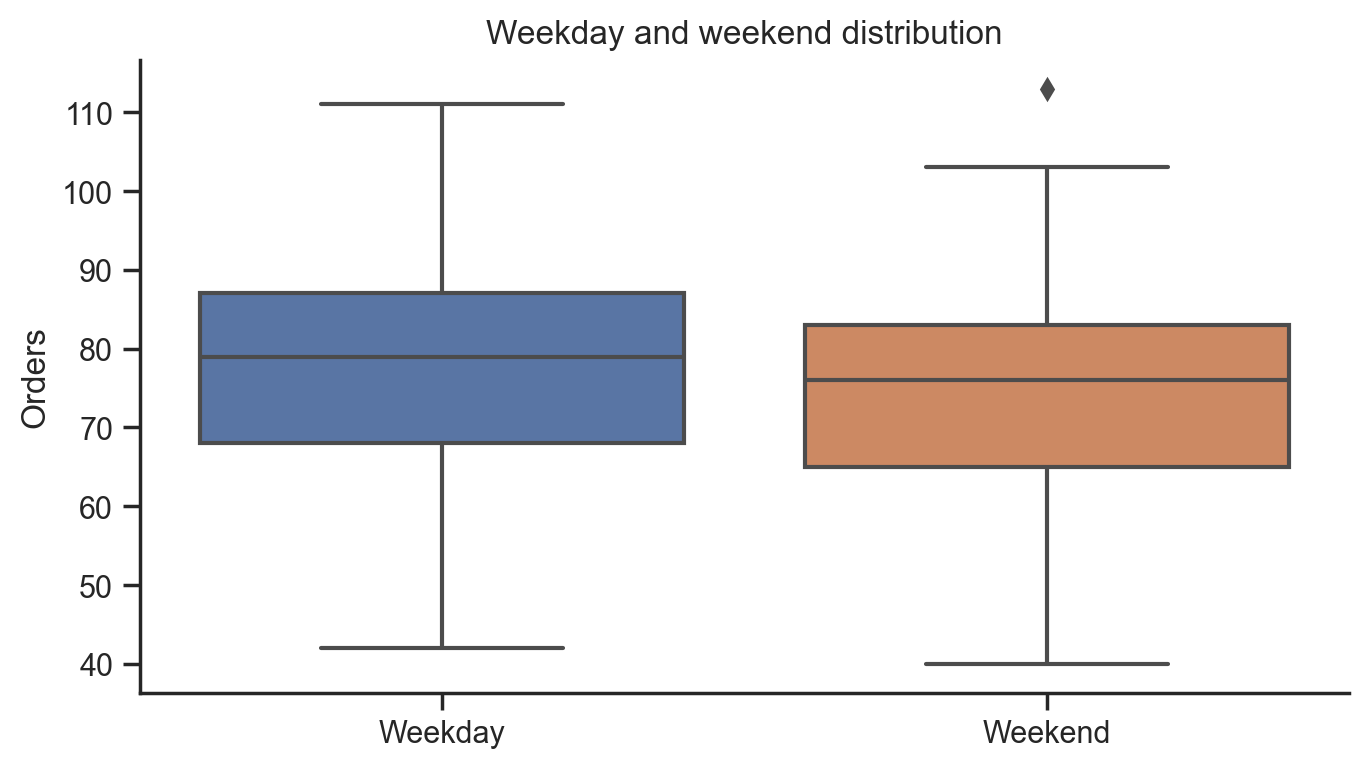

In [26]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df, x="type_of_day", y="orders_clean", ax=ax)
ax.set(title="Weekday and weekend distribution", xlabel=None, ylabel="Orders")
fig.tight_layout()
plt.show()

## Monthly seasonality

There is pattern that is repeated every year, demand peaks around April and September and a valley around June. A small upward trend can be seen, since the values of 2020 are lower than those of 2021, and those of 2021 are lower than those of 2022.

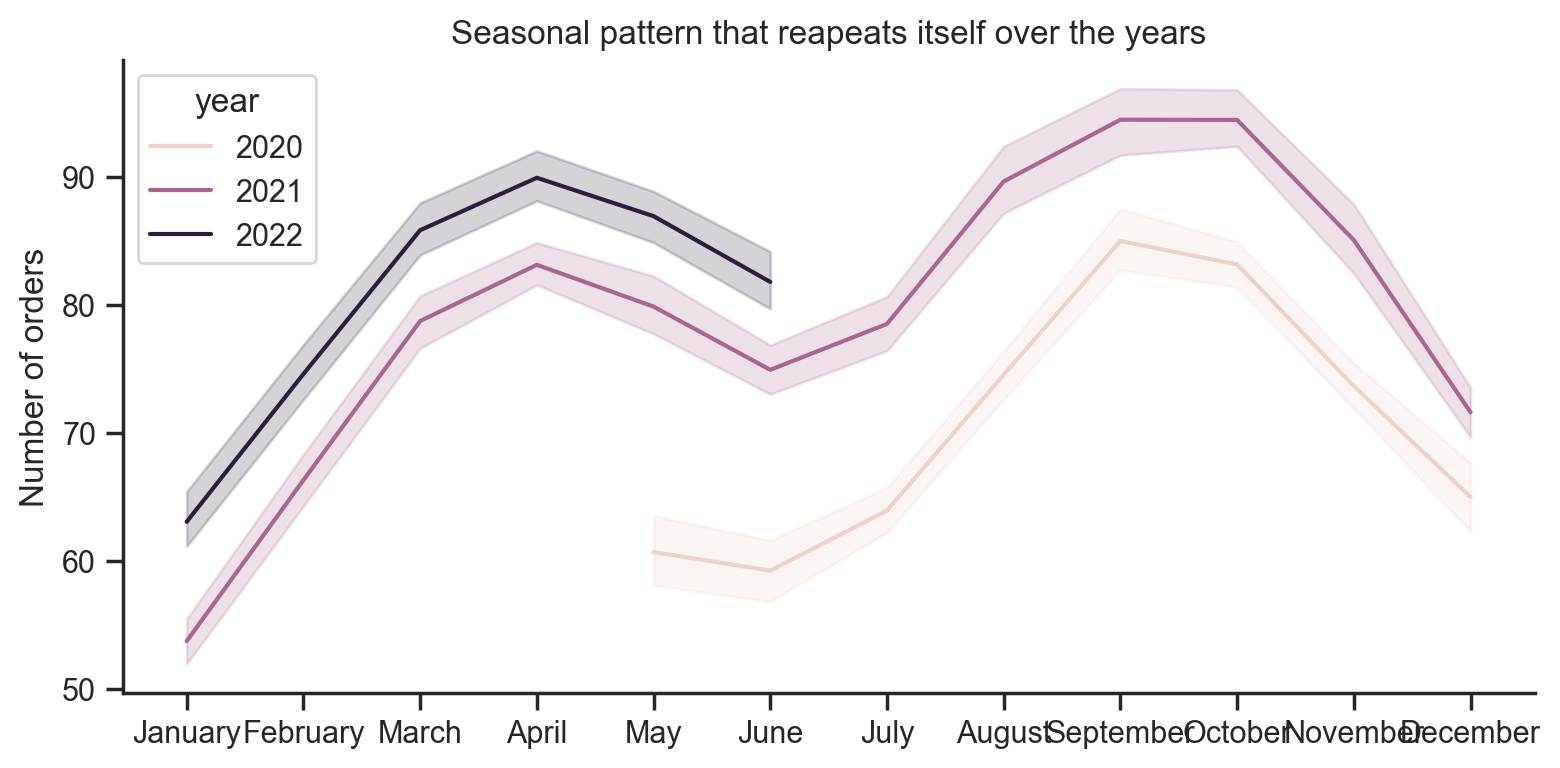

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=df, x="month", y="orders_clean", hue="year", ax=ax)
ax.set(
    title="Seasonal pattern that reapeats itself over the years",
    xlabel=None,
    ylabel="Number of orders",
)
fig.tight_layout()
plt.savefig(path_images / "orders_by_month.png")
plt.show()

## Lag plots

The figure below shows a scatterplot of the orders with their lags, where the x-axis shows the values of the orders $t$ periods ago and the y-axis shows the actual orders.

The further back we go, the lower the correlation. However, the lag 365 (not shown in the image below) is the one with the best correlation with the current value.

These are potential features to include in our model.

/Users/cespeleta/Projects/interview-wolt/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


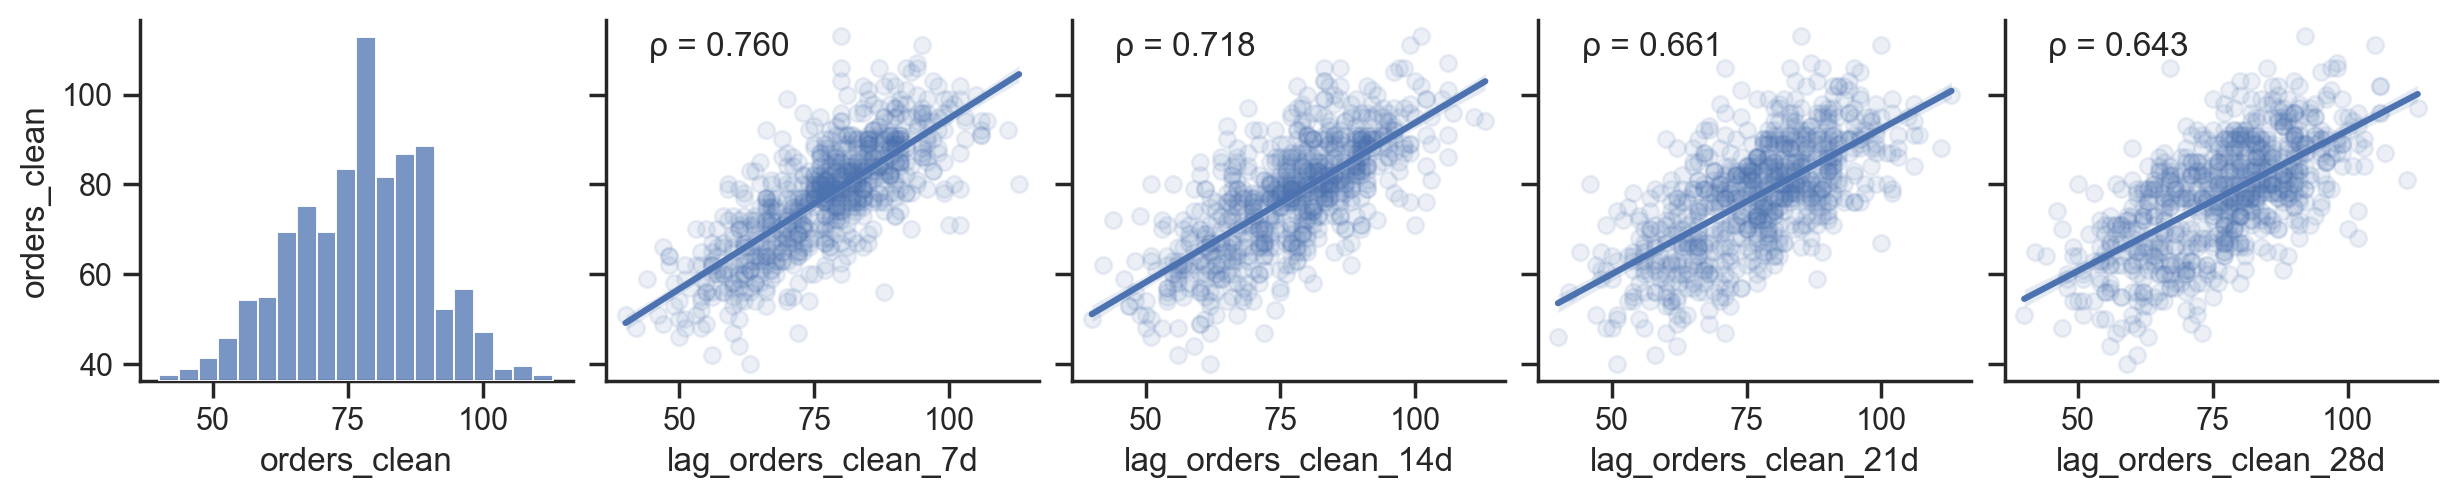

In [28]:
plot_lags(df, "orders_clean", lags=[7, 14, 21, 28])
plt.savefig(path_images / "orders_lag.png")
plt.show()

## Lagged features

As we have seen during the analysis, lags at 7 and 365 days seems to be good candidates to be used in our model. However, we cannot use lags of less than 14 days if we want to predict 14 days ahead.

In [29]:
target = "orders_clean"

In [30]:
columns = {
    "orders_clean": [7 * 2, 365],
    "temperature": [7 * 2],
}

In [31]:
for col, lags in columns.items():
    print(f"Processing lags for column: {col}")
    for lag in lags:
        print(f"- Processing lag: {lag}")
        df[f"lag_{col}_{lag}d"] = df[col].shift(lag).astype(np.float32)

Processing lags for column: orders_clean
- Processing lag: 14
- Processing lag: 365
Processing lags for column: temperature
- Processing lag: 14


In [32]:
df.dropna(subset=["lag_orders_clean_365d"], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index("date", inplace=True)

# Prediction intervals

Prediction intervals will be calculated from the cross validation errors. For each fold, we compute the residuals, create $n$ bootstraped samples, take the median of each sample and compute the standard deviation of the medians.

In [33]:
np.random.seed(2)
y_pred = np.random.randint(40, 80, size=14, dtype=int)
ti_false = calculate_prediction_intervals(y_pred, 12, time_interval=False)
ti_true = calculate_prediction_intervals(y_pred, 12, time_interval=True)

Prediction intervals get wider as they get farther away from the last training point, because as we move away in time there is more uncertainty.

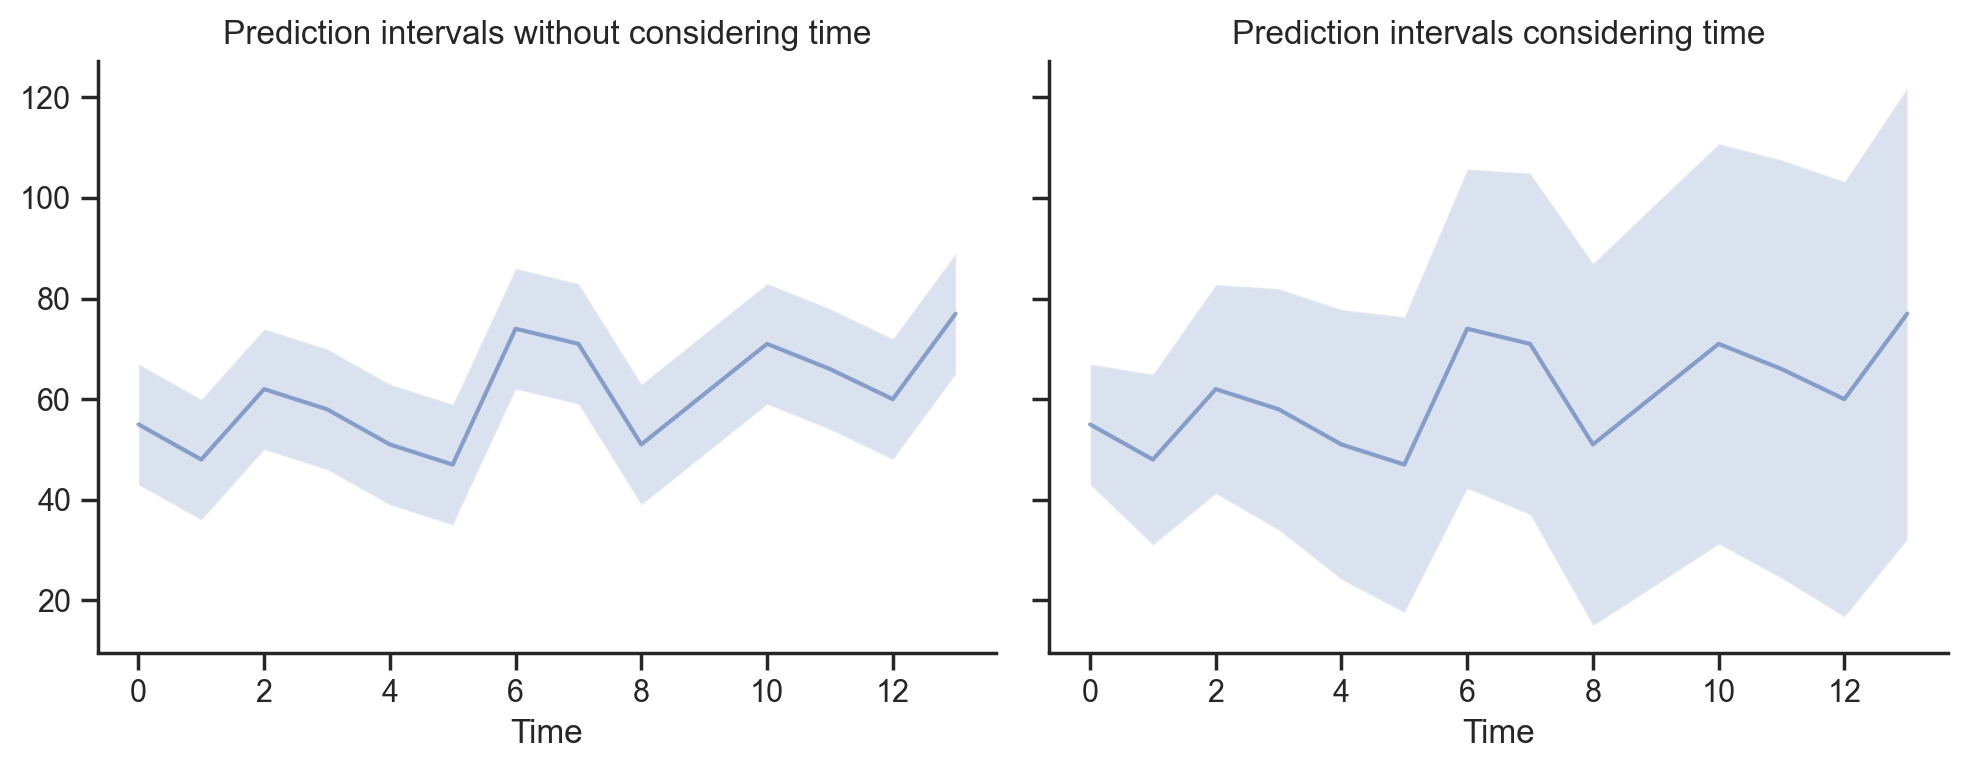

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(ti_false.loc[:, "y_pred"], alpha=0.6)
axs[0].fill_between(
    ti_false.index,
    ti_false.loc[:, "y_pred_upper"],
    ti_false.loc[:, "y_pred_lower"],
    alpha=0.2,
)
axs[0].set(
    title="Prediction intervals without considering time",
    xlabel="Time",
)
axs[1].plot(ti_true.loc[:, "y_pred"], alpha=0.6)
axs[1].fill_between(
    ti_true.index,
    ti_true.loc[:, "y_pred_upper"],
    ti_true.loc[:, "y_pred_lower"],
    alpha=0.2,
)
axs[1].set(
    title="Prediction intervals considering time",
    xlabel="Time",
)
fig.tight_layout()
plt.savefig(path_images / "prediction_intervals.png")
plt.show()

# Train / Test split

Split the data set into train and test based on time. The training set will be used to train the models and the test set to evaluate the expected model performance.

In [35]:
last_train_day = dt.date(2022, 6, 12)  # Sunday
first_test_day = last_train_day + dt.timedelta(days=1)  # Monday

print(f"Last training day: {last_train_day}")
print(f"First testing day: {first_test_day}")

Last training day: 2022-06-12
First testing day: 2022-06-13


In [36]:
train = df.query("index <= @last_train_day").copy()
test = df.query("index >= @first_test_day").copy()

## Cross validation

The cross validation setup should mimic the production scenario.

- Evaluate the model performance on 5 folds
- Time based splits
- Last training date must be Sunday
- First validation date must be Monday
- Compute model performance on the following 14 days (2 weeks)

In [37]:
tscv = TimeSeriesSplit(n_splits=5, test_size=7 * 2, max_train_size=7 * 4 * 12)

In [38]:
for i, (train_index, valid_index) in enumerate(tscv.split(train)):
    print(f"Fold {i}:")
    last_train_obs = train.iloc[train_index, :].query("index == index.max()")
    print(
        "- Last train date:  {}, {}, ({} samples)".format(
            last_train_obs.index.strftime("%Y-%m-%d")[-1],
            last_train_obs.weekday.iloc[-1],
            train.iloc[train_index,].shape[0],
        )
    )
    first_test_obs = train.iloc[valid_index, :].query("index == index.min()")
    print(
        "- First valid date: {}, {}, ({} samples)".format(
            first_test_obs.index.strftime("%Y-%m-%d")[-1],
            first_test_obs.weekday.iloc[-1],
            train.iloc[valid_index,].shape[0],
        )
    )

Fold 0:
- Last train date:  2022-04-03, Sunday, (336 samples)
- First valid date: 2022-04-04, Monday, (14 samples)
Fold 1:
- Last train date:  2022-04-17, Sunday, (336 samples)
- First valid date: 2022-04-18, Monday, (14 samples)
Fold 2:
- Last train date:  2022-05-01, Sunday, (336 samples)
- First valid date: 2022-05-02, Monday, (14 samples)
Fold 3:
- Last train date:  2022-05-15, Sunday, (336 samples)
- First valid date: 2022-05-16, Monday, (14 samples)
Fold 4:
- Last train date:  2022-05-29, Sunday, (336 samples)
- First valid date: 2022-05-30, Monday, (14 samples)


## Model performance

The model will be evaluated with the Root Mean Squared Error (RMSE) metric for its easy interpretation since it is in the same units as the series. If we were to evaluate the performance of many series we would have to think of another metric, such as the Mean Average Percentage Error (MAPE) to be able to compare the error between series. MAPE can also be used to evaluate the performance of this model and will be included in the analysis.

Bias is the tendency to either over-forecast (forecast is more than the actual) or under-forecast (forecast is less than the actual) leading to a forecasting error.

In [39]:
def normalized_bias_forecast(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Normalized forecast bias."""
    num = y_pred - y_true
    den = y_pred + y_true
    return np.sum(np.divide(num, den))

Coverage will be used to evaluate confidence intervals, that is,
the fraction of observations that fall between the intervals.

In [40]:
def coverage_fraction(
    y_true: np.ndarray, y_low: np.ndarray, y_high: np.ndarray
) -> float:
    """Fraction of observations that fall between the intervals."""
    return np.mean(np.logical_and(y_true >= y_low, y_true <= y_high))

# Modeling

Two type of models will be tested in this section, a linear regression model with regularization and a tree-based model.

Different tests have been carried out on the linear model to see which of the bests fits the data, i.e: differnetm sets of variables, ordinal encoding, one hot encoding, standard scaler, minmax scaler, etc.

A benchmark will be used as a reference of the performance of the models.

In [41]:
std_mult = 1.96  # Calculate intervals

In [42]:
bias_scorer = make_scorer(
    normalized_bias_forecast,
    greater_is_better=False,
)

scoring = {
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mape": "neg_mean_absolute_percentage_error",
    "neg_bias": bias_scorer,
}

## Utilities

In [43]:
def display_cv_metrics(cv_results: dict) -> None:
    """Display cross validation metrics."""
    train_rmse = -cv_results["train_neg_rmse"]
    test_rmse = -cv_results["test_neg_rmse"]
    train_mape = -100 * cv_results["train_neg_mape"]
    test_mape = -100 * cv_results["test_neg_mape"]
    train_bias = -cv_results["train_neg_bias"]
    test_bias = -cv_results["test_neg_bias"]
    test_coverage = cv_results["test_coverage"]

    print(
        "Root Mean Squared Error: {:<3} {:.2f} ± {:.2f} | {:.2f} ± {:.2f}".format(
            "",
            train_rmse.mean(),
            train_rmse.std(),
            test_rmse.mean(),
            test_rmse.std(),
        ),
        "Mean Absolute Percent Error: {:.2f} ± {:.2f} | {:.2f} ± {:.2f}".format(
            train_mape.mean(), train_mape.std(), test_mape.mean(), test_mape.std()
        ),
        "Forecast Bias: {:>12} {:.2f} ± {:.2f} | {:.2f} ± {:.2f}".format(
            "",
            train_bias.mean(),
            train_bias.std(),
            test_bias.mean(),
            test_bias.std(),
        ),
        "Coverage: {:>30} | {:.2f} ± {:.2f}".format(
            "", test_coverage.mean(), test_coverage.std()
        ),
        sep="\n",
    )

In [44]:
def evaluate(model, X, y, cv, std_multiplier):
    """Wrapper to cross validate models."""
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
    )
    cv_predictions = cross_validation_predict(cv_results["estimator"], X, y, cv=tscv)
    cv_predictions = cross_validation_intervals(cv_predictions, std_multiplier)
    cv_predictions.update({"test_coverage": cross_validation_coverage(cv_predictions)})
    cv_results.update(cv_predictions)
    display_cv_metrics(cv_results)
    return cv_results

## Benchmark

The forecast will be the demand observed in the last 14 days.

In [45]:
class BaseLineModelPreviousDays(BaseEstimator):
    """Predictions = actual demand onserved in the last 14 days."""

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        return X_test.loc[:, "lag_orders_clean_14d"].values

In [46]:
baseline = BaseLineModelPreviousDays()

It has a validation error of ~9 orders and a standard deviation of 2 orders. Slightly over-forecast and a coverage of 93% of the points.

In [47]:
cv_baseline_results = evaluate(
    baseline, X=train, y=train[target], cv=tscv, std_multiplier=std_mult
)

Root Mean Squared Error:     9.66 ± 0.04 | 8.77 ± 2.10
Mean Absolute Percent Error: 9.30 ± 0.09 | 7.78 ± 2.13
Forecast Bias:              -0.81 ± 0.30 | 0.07 ± 0.47
Coverage:                                | 0.93 ± 0.09


## Linear model

Linear regression with L2 regularization.

In [48]:
one_hot_encoder = OneHotEncoder(handle_unknown="error", sparse_output=False)
ordinal_encoder = OrdinalEncoder(dtype=int, handle_unknown="error")

In [49]:
alphas = np.logspace(-10, 10, 25)  # np.logspace(-6, 6, 25)
regressor = RidgeCV(alphas=alphas)

### Time features as integers

In this experiment time features such as month and day of the week will be encoded as numbers and `season` and `type_of_day` (weekday, weekend) will be one hot encoded.

In [50]:
numerical_columns = ["month_idx", "weekday_idx"]
categorical_columns = ["season", "type_of_day"]

features = numerical_columns + categorical_columns
print(f"Total number of features: {len(features)}")

Total number of features: 4


In [51]:
preprocessor = ColumnTransformer(
    [
        ("identity", "passthrough", numerical_columns),
        ("one_hot_encoder", one_hot_encoder, categorical_columns),
    ],
    remainder=MinMaxScaler(),
)
ordinal_linear_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("model", regressor),
    ]
)

In [52]:
cv_ordinal_results = evaluate(
    ordinal_linear_pipeline,
    X=train[features],
    y=train[target],
    cv=tscv,
    std_multiplier=std_mult,
)

Root Mean Squared Error:     7.70 ± 0.16 | 6.44 ± 2.29
Mean Absolute Percent Error: 7.57 ± 0.26 | 5.93 ± 1.98
Forecast Bias:              0.78 ± 0.04 | -0.09 ± 0.37
Coverage:                                | 0.91 ± 0.08


### Time features as categories

In this experiment all time variables will be treated as categorical columns and will encoded using one hot encoding.

In [53]:
numerical_columns = []
categorical_columns = ["season", "month", "weekday", "type_of_day"]

features = numerical_columns + categorical_columns
print(f"Total number of features: {len(features)}")

Total number of features: 4


In [54]:
preprocessor = ColumnTransformer(
    [("categorical", one_hot_encoder, categorical_columns)],
    remainder="passthrough",  # MinMaxScaler(),
)

one_hot_linear_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("model", regressor),
    ]
)

In [55]:
cv_ohe_results = evaluate(
    one_hot_linear_pipeline,
    X=train[features],
    y=train[target],
    cv=tscv,
    std_multiplier=std_mult,
)

Root Mean Squared Error:     5.70 ± 0.03 | 5.45 ± 1.38
Mean Absolute Percent Error: 5.22 ± 0.06 | 4.71 ± 1.08
Forecast Bias:              0.44 ± 0.01 | -0.16 ± 0.21
Coverage:                                | 0.91 ± 0.08


Of the 4 initial variables, 25 have been generated, which is why it is important to use regularization.

In [56]:
n_features = preprocessor.fit_transform(train[features]).shape[1]
print(f"Number of features used in this model: {n_features}")

Number of features used in this model: 25


### Temperature and media 

So far we have seen that using one hot encoding we have better results than with numeric variables. Now we are going to add the temperature and marketing variables into the model.

In [57]:
numerical_columns = ["lag_temperature_14d", "media_spend"]
categorical_columns = ["season", "month", "weekday", "type_of_day"]

features = numerical_columns + categorical_columns
print(f"Total number of features: {len(features)}")

Total number of features: 6


In [58]:
preprocessor = ColumnTransformer(
    [("categorical", one_hot_encoder, categorical_columns)],
    remainder=MinMaxScaler(),
)

temperature_linear_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("model", regressor),
    ]
)

Amazing results, this model has an RMSE of 4.62 orders, which is an 15% reduction from the previous model and a  47% reduction from the benchmark.

In [59]:
cv_temperature_results = evaluate(
    temperature_linear_pipeline,
    X=train[features],
    y=train[target],
    cv=tscv,
    std_multiplier=std_mult,
)

Root Mean Squared Error:     4.82 ± 0.03 | 4.62 ± 1.22
Mean Absolute Percent Error: 4.62 ± 0.05 | 3.96 ± 1.06
Forecast Bias:              0.35 ± 0.01 | -0.14 ± 0.15
Coverage:                                | 0.94 ± 0.05


## Gradient Boosting

For completeness, evaluate the performance of a tree-based model.

In [60]:
numerical_columns = ["lag_temperature_14d", "media_spend"]
categorical_columns = ["season", "month", "weekday", "type_of_day"]

features = numerical_columns + categorical_columns
print(f"Total number of features: {len(features)}")

Total number of features: 6


In [61]:
tree_regressor = GradientBoostingRegressor(
    n_estimators=50, max_depth=3, random_state=42
)

In [62]:
preprocessor = ColumnTransformer(
    [("categorical", ordinal_encoder, categorical_columns)],
    remainder="passthrough",
)

gbm_pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("model", tree_regressor),
    ]
)

In [63]:
cv_gbm_results = evaluate(
    gbm_pipeline, X=train[features], y=train[target], cv=tscv, std_multiplier=std_mult
)

Root Mean Squared Error:     4.41 ± 0.04 | 4.68 ± 1.13
Mean Absolute Percent Error: 4.35 ± 0.12 | 4.19 ± 0.96
Forecast Bias:              0.45 ± 0.02 | -0.15 ± 0.14
Coverage:                                | 0.93 ± 0.09


In [64]:
n_features = preprocessor.fit_transform(train[features]).shape[1]
print(f"Number of features used in this model: {n_features}")

Number of features used in this model: 6


<div class="alert alert-info" role="alert">
  The best model has been the linear regression using temperature and marketing variables, followed by the gradient boosting tree.
</div>

# Forecast visualization

To gain insight into the results it is always useful visualize the forecasts.

In [65]:
# Visualize predictions on one fold
all_splits = list(tscv.split(train, train[features]))

fold_idx = 2
train_idx, test_idx = all_splits[fold_idx]

In [66]:
# Number of observations to show of actual orders
last_days = slice(-7 * 4, None)

# Concat train and test data (real values)
train_valid_idx = np.concatenate([train_idx[last_days], test_idx])

## Point forecast

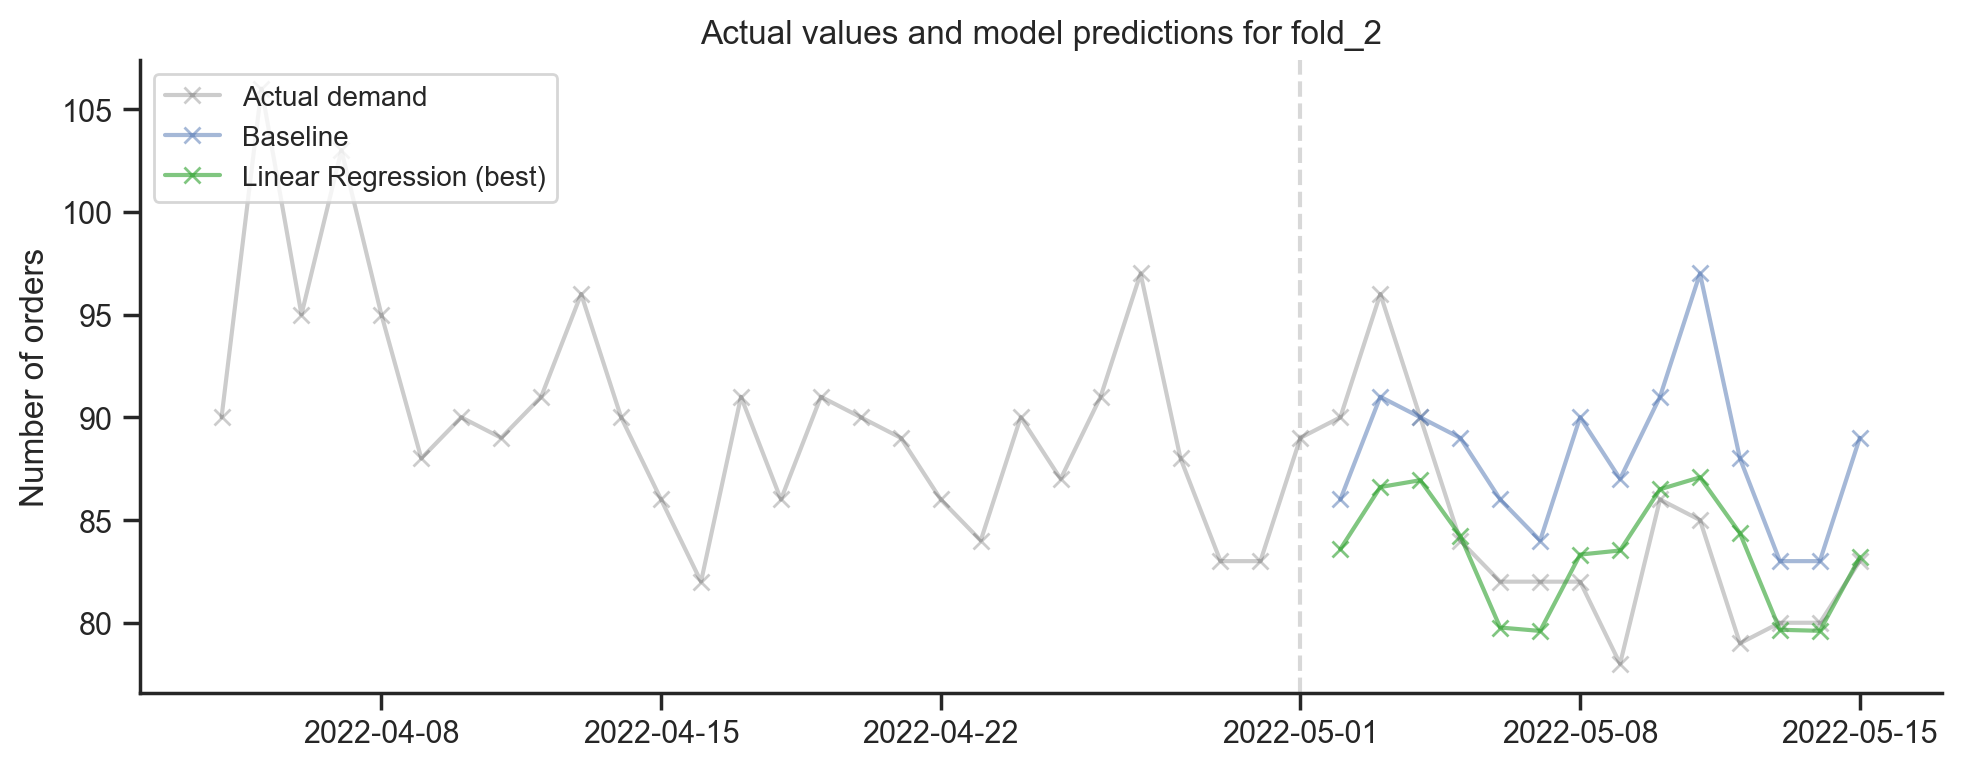

In [67]:
fig, ax = plt.subplots(figsize=(10, 4))

actual_values = df.iloc[train_valid_idx].orders_clean
ax.plot(actual_values, "x-", color="black", alpha=0.2, label="Actual demand")
plt.axvline(df.index[train_idx[-1]], color="gray", linestyle="--", alpha=0.3)

data = cv_baseline_results["test_predictions"][fold_idx].loc[:, "y_pred"]
ax.plot(data, "x-", alpha=0.5, label="Baseline")

data = cv_temperature_results["test_predictions"][fold_idx].loc[:, "y_pred"]
ax.plot(data, "x-", alpha=0.6, color="tab:green", label="Linear Regression (best)")

ax.legend(loc="upper left", fontsize=10)
ax.set(
    ylabel="Number of orders",
    title=f"Actual values and model predictions for fold_{fold_idx}",
)
fig.tight_layout()
plt.savefig(path_images / f"point_forecast_lr_fold{fold_idx}.png")
plt.show()

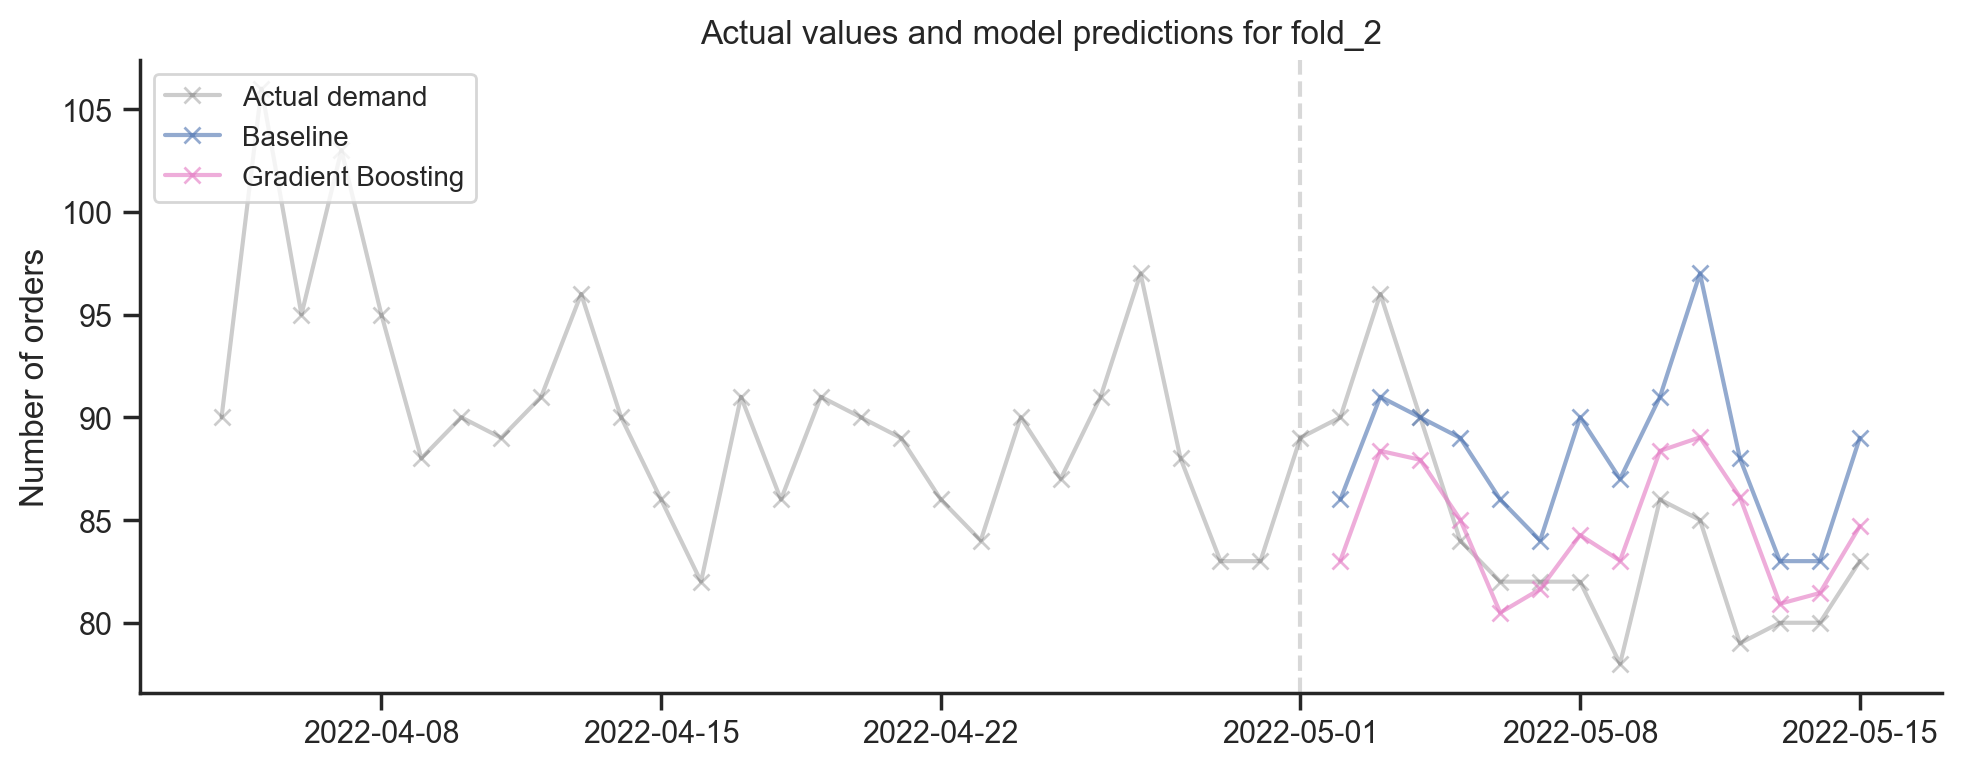

In [68]:
fig, ax = plt.subplots(figsize=(10, 4))

actual_values = df.iloc[train_valid_idx].orders_clean
ax.plot(actual_values, "x-", color="black", alpha=0.2, label="Actual demand")
plt.axvline(df.index[train_idx[-1]], color="gray", linestyle="--", alpha=0.3)

data = cv_baseline_results["test_predictions"][fold_idx].loc[:, "y_pred"]
ax.plot(data, "x-", alpha=0.6, label="Baseline")

data = cv_gbm_results["test_predictions"][fold_idx].loc[:, "y_pred"]
ax.plot(data, "x-", alpha=0.6, color="tab:pink", label="Gradient Boosting")

ax.legend(loc="upper left", fontsize=10)
ax.set(
    ylabel="Number of orders",
    title=f"Actual values and model predictions for fold_{fold_idx}",
)
fig.tight_layout()
plt.savefig(path_images / f"point_forecast_gbm_fold{fold_idx}.png")
plt.show()

## Confidence intervals

Look at the confidence intervals

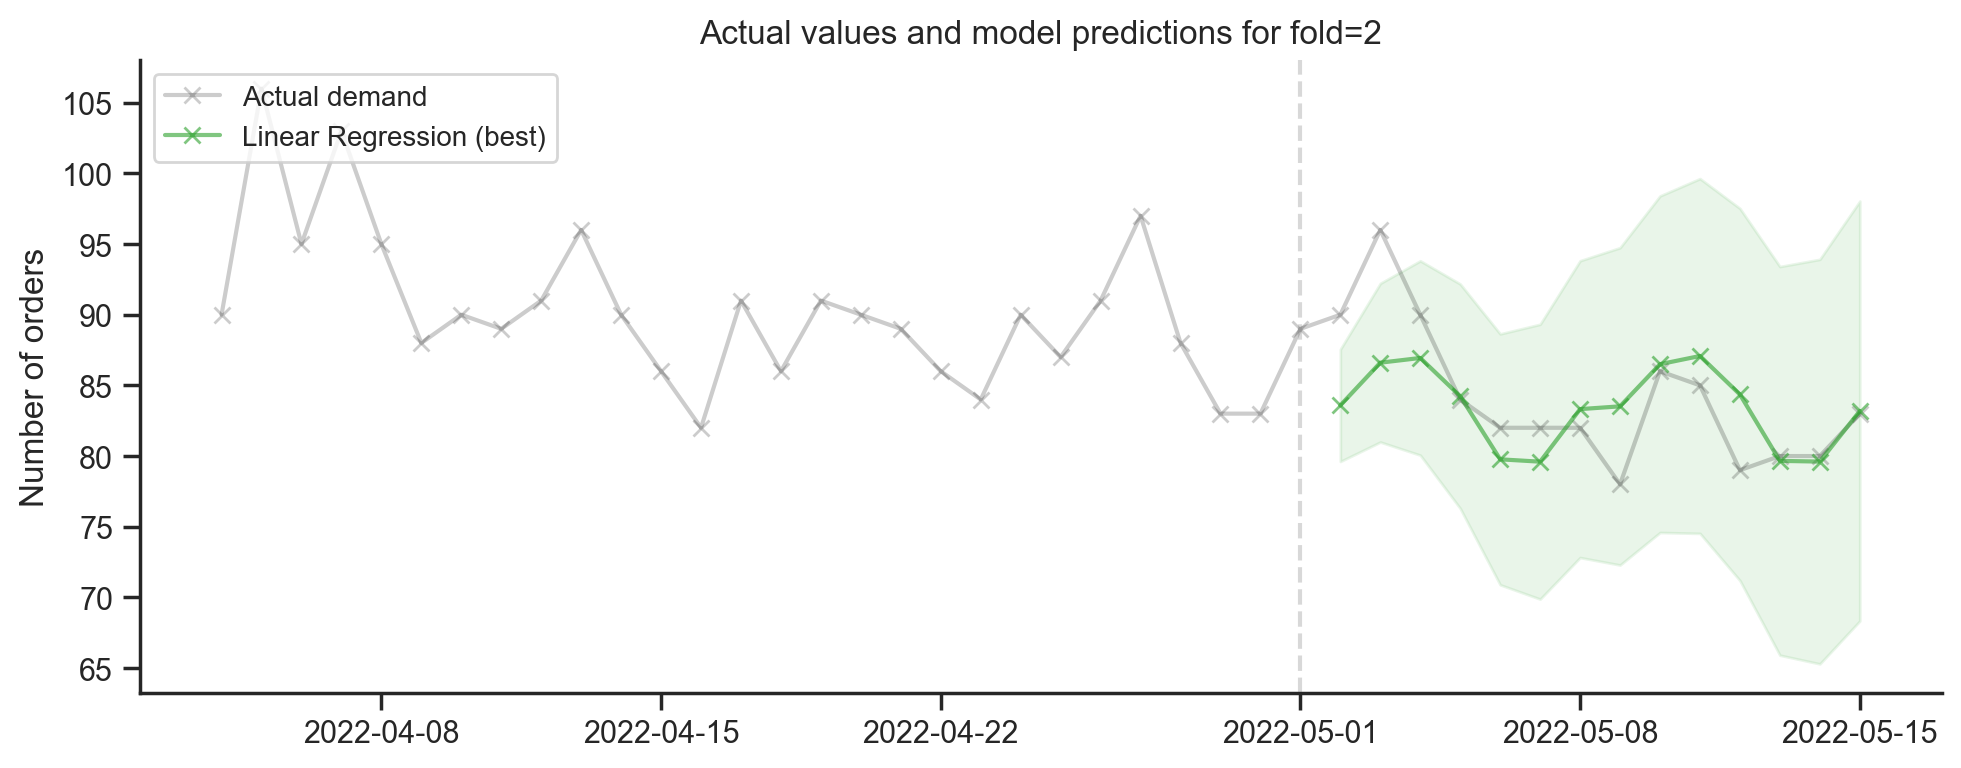

In [69]:
fig, ax = plt.subplots(figsize=(10, 4))

actual_values = df.iloc[train_valid_idx].orders_clean
ax.plot(actual_values, "x-", color="black", alpha=0.2, label="Actual demand")
plt.axvline(df.index[train_idx[-1]], color="gray", linestyle="--", alpha=0.3)

data = cv_temperature_results["test_predictions"][fold_idx]
ax.plot(
    data.loc[:, "y_pred"],
    "x-",
    alpha=0.6,
    color="tab:green",
    label="Linear Regression (best)",
)

ax.fill_between(
    data.index,
    data.loc[:, "y_pred_upper"],
    data.loc[:, "y_pred_lower"],
    color="tab:green",
    alpha=0.1,
)

ax.legend(loc="upper left", fontsize=10)
ax.set(
    ylabel="Number of orders",
    title=f"Actual values and model predictions for fold={fold_idx}",
)
fig.tight_layout()
plt.savefig(path_images / f"interval_forecast_lr_fold{fold_idx}.png")
plt.show()

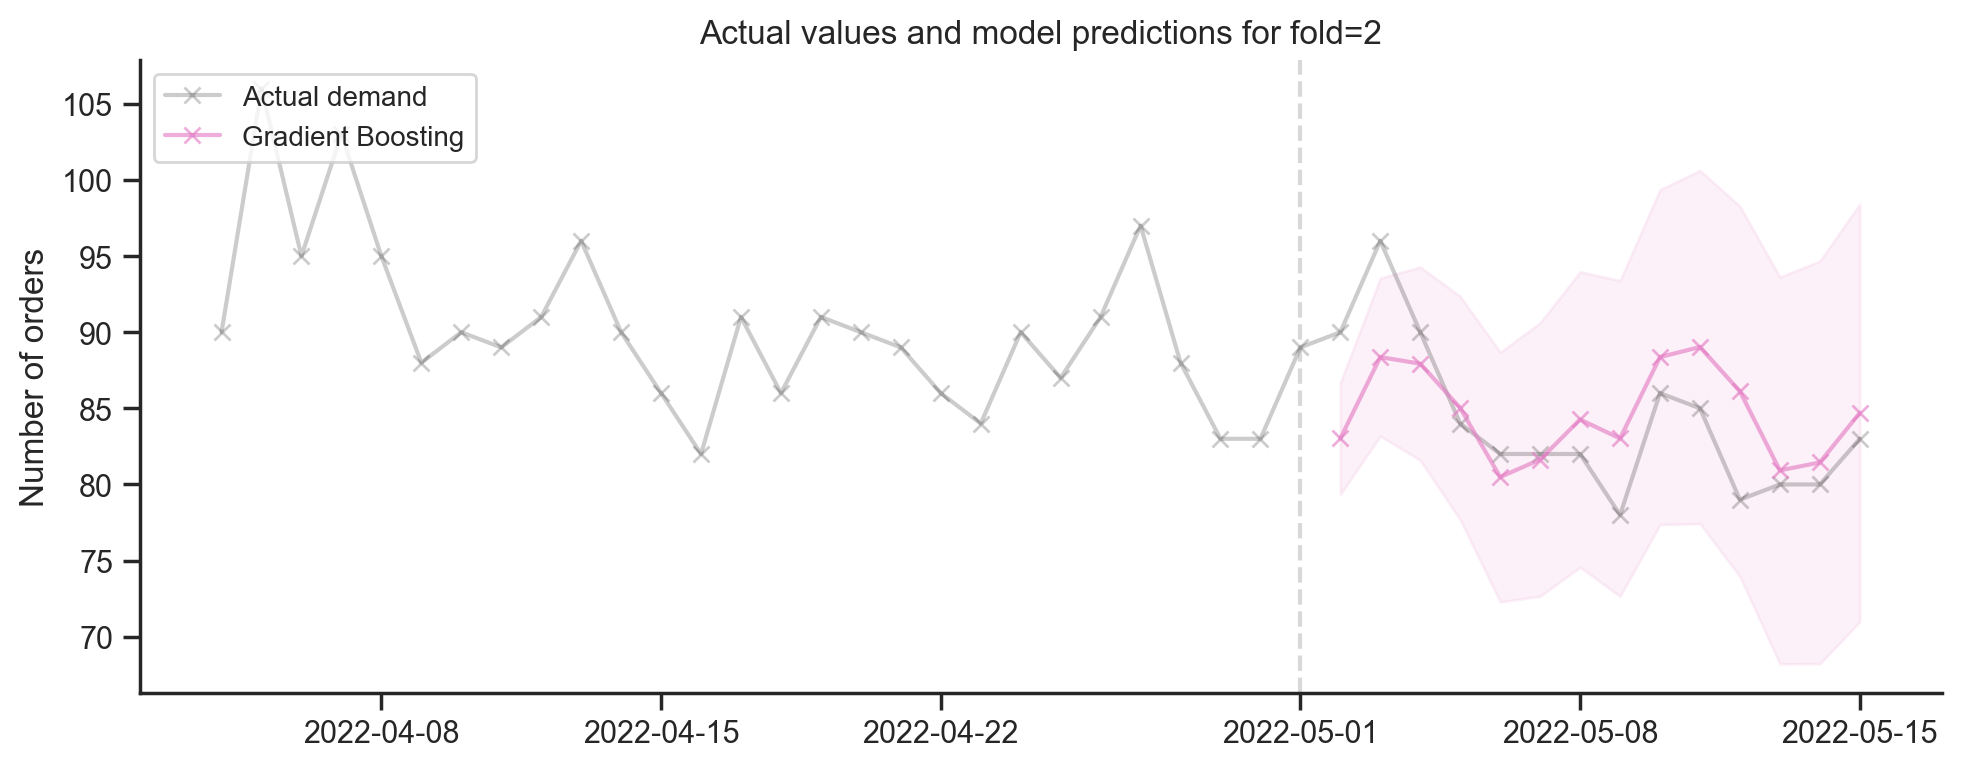

In [70]:
fig, ax = plt.subplots(figsize=(10, 4))

actual_values = df.iloc[train_valid_idx].orders_clean
ax.plot(actual_values, "x-", color="black", alpha=0.2, label="Actual demand")
plt.axvline(df.index[train_idx[-1]], color="gray", linestyle="--", alpha=0.3)

data = cv_gbm_results["test_predictions"][fold_idx]
ax.plot(
    data.loc[:, "y_pred"],
    "x-",
    alpha=0.6,
    color="tab:pink",
    label="Gradient Boosting",
)

ax.fill_between(
    data.index,
    data.loc[:, "y_pred_upper"],
    data.loc[:, "y_pred_lower"],
    color="tab:pink",
    alpha=0.1,
)

ax.legend(loc="upper left", fontsize=10)
ax.set(
    ylabel="Number of orders",
    title=f"Actual values and model predictions for fold={fold_idx}",
)
fig.tight_layout()
plt.savefig(path_images / f"interval_forecast_gbm_fold{fold_idx}.png")
plt.show()

# Predict on the test set

Predict the test set using the best model and comment the expected performance of the model.

In [71]:
best_model = temperature_linear_pipeline
cv_best_model = cv_temperature_results

In [72]:
# re-train model with all train data
best_model = best_model.fit(train[features], train[target])

# make predictions on the test set
y_pred = best_model.predict(test[features])
y_true = test.loc[:, target].values

In [73]:
# concatena residuals and compute
residuals = np.concatenate([r for r in cv_best_model["test_residuals"]])

# Compute confidence intervals
ci = get_residuals_quantile(residuals, std_multiplier=std_mult)
preds_df = calculate_prediction_intervals(y_pred, ci)
preds_df.set_index(test.index, inplace=True)

Expected performance of the model

In [74]:
print(
    "Root Mean Squared Error: {:.2f}".format(
        mean_squared_error(y_true, y_pred, squared=False)
    ),
    "Mean Absolute Percent Error: {:.2f}".format(
        100 * mean_absolute_percentage_error(y_true, y_pred)
    ),
    "Coverage: {:.2f}".format(
        coverage_fraction(y_true, preds_df.y_pred_lower, preds_df.y_pred_upper)
    ),
    sep="\n",
)

Root Mean Squared Error: 6.60
Mean Absolute Percent Error: 5.73
Coverage: 0.78


## Plot predictions

In [75]:
train_test_idx = np.concatenate([train.index[last_days], test.index])

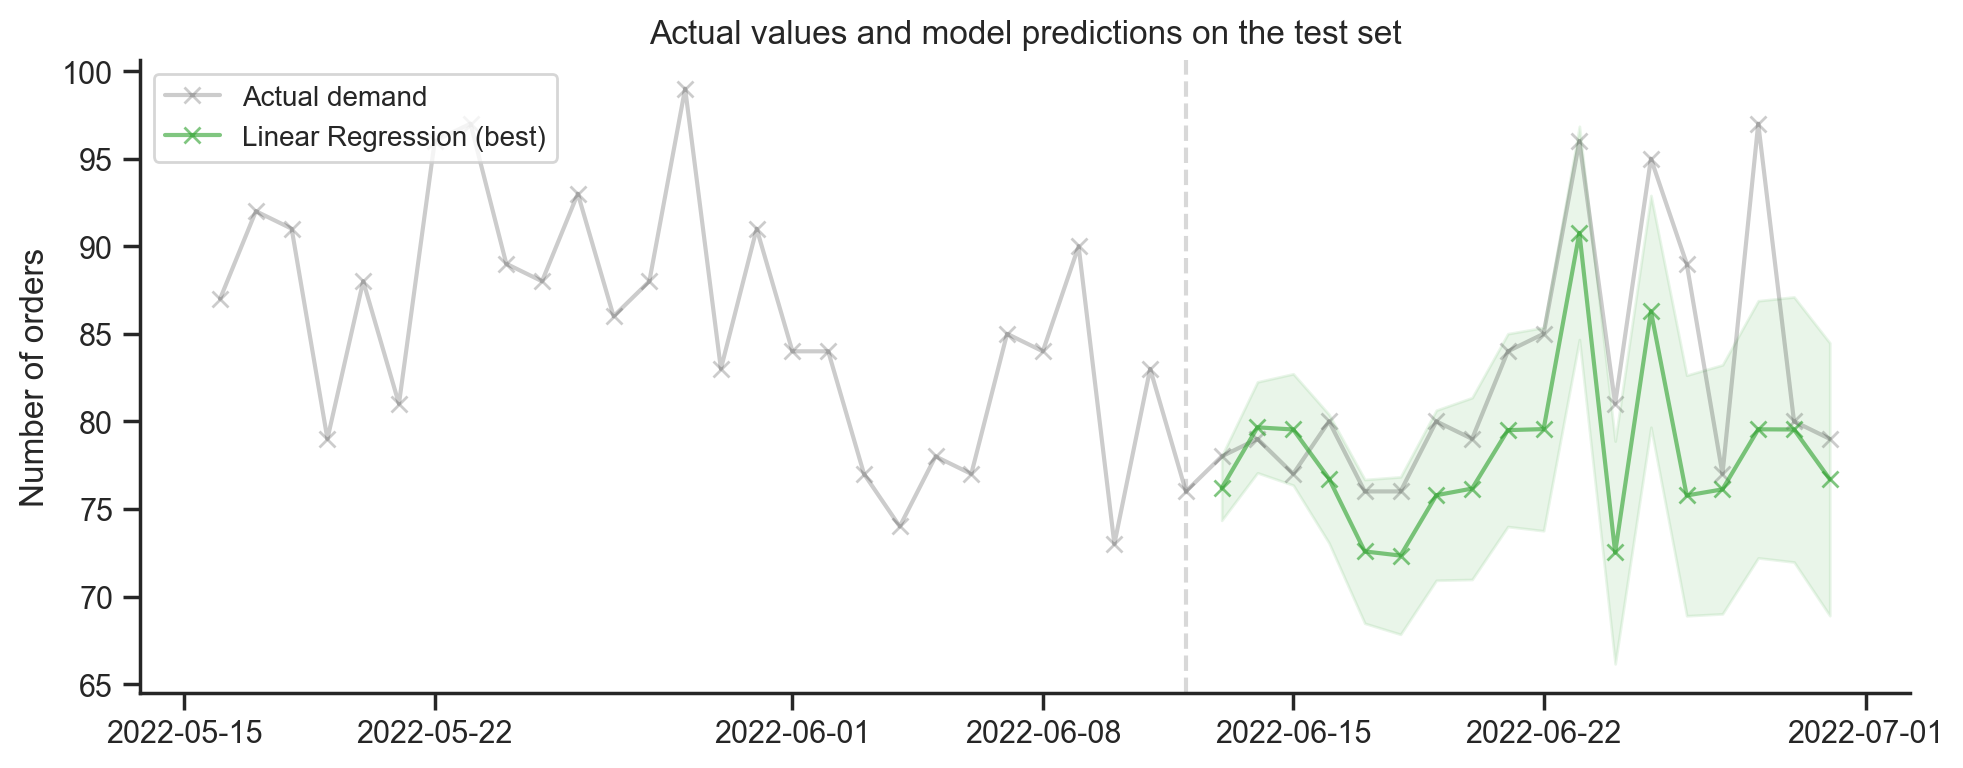

In [76]:
fig, ax = plt.subplots(figsize=(10, 4))

actual_values = df.loc[train_test_idx].orders_clean
ax.plot(actual_values, "x-", color="black", alpha=0.2, label="Actual demand")
plt.axvline(train.index[-1], color="gray", linestyle="--", alpha=0.3)

ax.plot(
    preds_df.loc[:, "y_pred"],
    "x-",
    alpha=0.6,
    color="tab:green",
    label="Linear Regression (best)",
)

ax.fill_between(
    preds_df.index,
    preds_df.loc[:, "y_pred_upper"],
    preds_df.loc[:, "y_pred_lower"],
    color="tab:green",
    alpha=0.1,
)

ax.legend(loc="upper left", fontsize=10)
ax.set(
    ylabel="Number of orders",
    title=f"Actual values and model predictions on the test set",
)
fig.tight_layout()
plt.savefig(path_images / f"forecast_lr_testset.png")
plt.show()

## Re-train pipeline

As a best practice, once the best model has been selected, one should retrain it on the entire dataset.

In [77]:
best_model_prod = best_model.fit(df[features], df[target])

In the specific case of scikit-learn, it may be better to use joblib instead of pickle (dump & load), which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators, but can only pickle to the disk and not to a string. [scikit-learn model persistence](https://scikit-learn.org/stable/model_persistence.html)

In [78]:
path_models = Path("models")
Path.mkdir(path_models, exist_ok=True)

In [79]:
dump(best_model_prod, path_models / "forecasting_pipeline.joblib")

['models/forecasting_pipeline.joblib']

# Next steps

- Look at the ACF to understand seasonlitu
- Decompose series and look at its comopnents? Does any of them correlated with the covariates?
- Explore other methos to fix outliers (if needed)
- Model seasonality using trigonometric features (sin/cos)
- Modeling marketing spend as suggested during the analysis
- Try other models
- Fine tune parameters of the GBM model
- Interactions on linear models